In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from faces_clustering import Clusterer, is_image, get_files_folder

Using TensorFlow backend.


In [2]:
import random
random.seed(42)

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
backbones = ['resnet50','senet50','vgg16']

# Checking Classes

In [19]:
df_embs = pd.read_pickle(f'../data/leg55_{backbones[2]}.pkl')

In [20]:
df_embs['classes'] = df_embs.urls.apply(lambda x: x.split('\\')[-2])

In [21]:
df_embs.to_pickle(f'../data/leg55_{backbones[2]}.pkl')

# DataSeparation

In [22]:
df_embs = pd.read_pickle(f'../data/leg55_{backbones[0]}.pkl')

In [23]:
test_index = df_embs.sample(frac=1, random_state=42).groupby('classes').head(1).sort_values('classes').index

In [25]:
for backbone in backbones:
    df_backbone = pd.read_pickle(f'../data/leg55_{backbone}.pkl')
    df_test = df_backbone.loc[test_index].copy()
    df_train = df_backbone.loc[df_embs.index.difference(test_index)].copy()
    
    df_train.to_pickle(f'../data/train_leg55_{backbone}.pkl')
    df_test.to_pickle(f'../data/test_leg55_{backbone}.pkl')

# Clustering Train

In [28]:
all_clusters = {}
for backbone in backbones:
    df_train = pd.read_pickle(f'../data/train_leg55_{backbone}.pkl')
    clusterer = Clusterer(n_clusters=513, face_embeddings = df_train,algs=[
        'kmeans', 'affinity', 'agglomerative'])
    clusters, models_inst = clusterer.clusterize(normalize=False)
    
    all_clusters[backbone] = clusters

c:\users\paulo\.virtualenvs\face_clustering-td_v2agr\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)
c:\users\paulo\.virtualenvs\face_clustering-td_v2agr\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [29]:
dt_clusters = pd.concat(all_clusters.values(), keys = all_clusters.keys())

In [30]:
dt_clusters.to_pickle('../data/clusters_train_leg55.pkl')

In [31]:
dt_clusters = pd.read_pickle('../data/clusters_train_leg55.pkl')

In [32]:
print(f"Train Size: {dt_clusters.loc['resnet50'].shape[0]}")

Train Size: 8490


## Evaluating Train

In [33]:
from sklearn import metrics

In [34]:
df_all = {}
for backbone in backbones:
    clusters = dt_clusters.loc[backbone]
    
    cluster_cols = [c for c in clusters.columns if str(c).startswith('cluster')]
    labels_true = clusters.classes.values
    
    dict_results = {}
    for col in cluster_cols:
        labels_pred = clusters[col].values

        dict_results[col] = [metrics.homogeneity_score(labels_true,labels_pred),
                            metrics.completeness_score(labels_true, labels_pred),
                            metrics.v_measure_score(labels_true, labels_pred)]
    df_all[backbone] = pd.DataFrame.from_dict(dict_results, orient='index', columns=[
        'Homogeneity Score', 'Completeness Score', 'V-Measure'])
    
df_all_results = pd.concat(df_all.values(), keys=df_all.keys())
    

In [35]:
df_all_results

Homogeneity Score  Completeness Score  \
resnet50 cluster_kmeans                   0.96652             0.96752   
         cluster_affinity                 0.00000             1.00000   
         cluster_agglomerative            0.98215             0.97979   
senet50  cluster_kmeans                   0.97254             0.97256   
         cluster_affinity                 0.98594             0.95577   
         cluster_agglomerative            0.98618             0.98332   
vgg16    cluster_kmeans                   0.83400             0.84155   
         cluster_affinity                 0.00000             1.00000   
         cluster_agglomerative            0.88985             0.89289   

                                V-Measure  
resnet50 cluster_kmeans           0.96702  
         cluster_affinity         0.00000  
         cluster_agglomerative    0.98096  
senet50  cluster_kmeans           0.97255  
         cluster_affinity         0.97062  
         cluster_agglomerative    0.98475  
vgg16    cluster_kmeans           0.83776  
         cluster_affinity         0.00000  
         cluster_agglomerative    0.89137

In [38]:
df_all_results.to_csv('../results/train_clusters.csv')

# Test

In [12]:
from faces_clustering import FaceSearcher
backbone = backbones[1]

In [13]:
df_embs = pd.read_pickle('../data/clusters_train_leg55.pkl').loc[backbone]

In [14]:
print(backbone)
df_embs.head()

senet50


,urls,embeddings,classes,cluster_kmeans,cluster_affinity,cluster_agglomerative
0,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.0996729, 0.028490392, 0.20510468, 0.5868249...",105112_b,404,0,422
1,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.086341664, 0.13112758, 0.0015521318, 0.2116...",105112_b,404,0,422
2,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.10442628, 0.11352078, 0.7367716, 2.401755, ...",105112_b,404,0,422
3,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.06998727, 3.4273074, 0.0, 2.3481488, 0.0052...",105112_b,24,548,209
4,C:/Users/paulo/Documents/FacesProject/slnp_fac...,"[0.10927686, 0.12103541, 2.4254398, 0.02788562...",105112_b,404,0,422


In [15]:
searcher = FaceSearcher(face_embs = df_embs, classes_col = 'cluster_agglomerative')

In [9]:
df_test = pd.read_pickle('../data/test_leg55_senet50.pkl')

In [10]:
df_test[['urls','classes']].loc[df_test['classes'] == '73674_b'].urls.values

array(['C:/Users/paulo/Documents/FacesProject/slnp_faces_leg_55\\73674_b\\13_0.jpg'],
      dtype=object)

In [11]:
print(f"Test size is {df_test.shape[0]}")

Test size is 513


In [12]:
embs_query = [l.tolist() for l in df_test.embeddings.values]

In [13]:
_, results = searcher.closest_centroids(embs_query = embs_query)

In [19]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))

In [20]:
def m1(x, k):
    m1 = softmax((1/x).nlargest(k)).head(1)
    return (m1.index.values[0],m1.values[0])

In [16]:
pcts = [m1(r,5)[1] for r in results]

In [17]:
np.mean(np.array(pcts)>=0.5)

0.9454191033138402

In [18]:
np.mean(np.array(pcts))

0.8880381713641167

In [19]:
import matplotlib.pyplot as plt

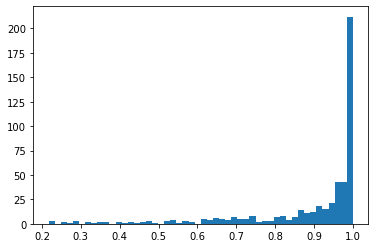

In [20]:
_ = plt.hist(pcts, bins=50)

In [21]:
df_test['results'] = results

In [22]:
mode_clusters = df_embs.groupby('cluster_agglomerative')['classes'].apply(lambda x: x.value_counts(dropna=False).idxmax())

In [23]:
classes_by_cluster = df_embs.groupby('cluster_agglomerative')['classes'].apply(set)

In [24]:
any_k = []
mode_k = []
has_class_k = []

for k in range(2,11):
    p_clusters = df_test['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    any_k.append(np.mean(p_clusters != -1))
    #print(f"{k}: Assigned to any: {any_k[-1]}")
    mode_k.append((df_test.classes == p_clusters.map(mode_clusters)).mean())
    #print(f"{k}: Assigned to cluster of mode: {mode_k[-1]}")
    
    comp = []
    for myclass, classes in zip(df_test.classes,p_clusters.map(classes_by_cluster)):
        comp.append(classes == classes and myclass in classes)
    has_class_k.append(np.mean(comp))    
    #print(f"{k}: Assigned to cluster with class in the cluster {has_class_k[-1]}")

In [25]:
df_results = pd.DataFrame(np.transpose([any_k, mode_k, has_class_k]),
             index = range(2,11), columns=['Any_Cluster', 'Mode Equal to Class', 'Class is present in cluster'])
df_results

,Any_Cluster,Mode Equal to Class,Class is present in cluster
2,1.00000,0.94737,0.98246
3,0.97076,0.93957,0.96881
4,0.95517,0.92982,0.95322
5,0.94542,0.92203,0.94347
6,0.93567,0.91618,0.93372
7,0.92788,0.91033,0.92593
8,0.91813,0.90448,0.91618
9,0.90448,0.89084,0.90253
10,0.89474,0.88109,0.89279


In [34]:
df_results.to_csv('../results/test_clusters.csv')

## Checking wrong classes

In [26]:
p_clusters = df_test['results'].apply(lambda x: m1(x,2)[0] if m1(x,2)[1] >= 0.5 else -1)

In [27]:
classes_wrong = df_test.loc[df_test.classes != p_clusters.map(mode_clusters)].classes

In [28]:
classes_right = df_test.loc[df_test.classes == p_clusters.map(mode_clusters)].classes

In [29]:
classes_count = df_embs.groupby('classes')['urls'].count()

In [30]:
classes_count.loc[classes_count<=5].count()

23

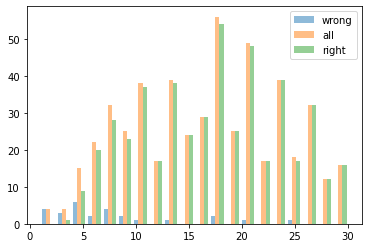

In [31]:
import matplotlib.pyplot as plt

_ = plt.hist([classes_wrong.map(classes_count), classes_count, classes_right.map(classes_count)], 
    density=False, bins=20, alpha=0.5, label=['wrong', 'all', 'right'])
_ = plt.legend()
#_ = plt.hist(, density=True, bins=12, alpha=0.5,label = 'class dist')

In [32]:
def fxs(x):
    if x < 6:
        return '1-5'
    if x < 11:
        return '6-10'
    if x < 16:
        return '11-15'
    if x < 21:
        return '16-20'
    if x < 26:
        return '21-25'
    return '26-30'

In [33]:
df_fxs_count = pd.concat([classes_wrong.map(classes_count).apply(fxs).value_counts(),
            classes_right.map(classes_count).apply(fxs).value_counts()], axis=1).reindex(
    ['1-5','6-10','11-15','16-20','21-25','26-30'])
df_fxs_count

,classes,classes
1-5,13.00000,10
6-10,8.00000,87
11-15,2.00000,100
16-20,3.00000,135
21-25,1.00000,94
26-30,nan,60


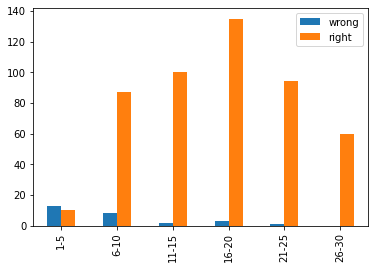

In [34]:
df_fxs_count.columns = ['wrong','right']
df_fxs_count.plot.bar()

# LFW

In [5]:
from faces_clustering import FeatureExtractor

In [6]:
path = 'C:/Users/paulo/Documents/0_LFW_dataset'

In [7]:
lfw = get_files_folder(path, criteria=is_image)

In [8]:
sample = random.sample(lfw, 513)

In [9]:
df_lfw = FeatureExtractor('senet50').extract(sample)
df_lfw.head(3)

,urls,embeddings
0,C:/Users/paulo/Documents/0_LFW_dataset\Rebecca...,"[0.15234976, 0.27424225, 0.0041644853, 0.76744..."
1,C:/Users/paulo/Documents/0_LFW_dataset\Cathy_F...,"[0.009776502, 0.020092016, 0.24820538, 0.33791..."
2,C:/Users/paulo/Documents/0_LFW_dataset\Alvaro_...,"[0.23451443, 1.3808557, 4.2913017, 1.1574467, ..."


In [10]:
lfw_query = [l.tolist() for l in df_lfw.embeddings.values]

In [16]:
_, results_lfw = searcher.closest_centroids(embs_query = lfw_query)

In [17]:
df_lfw['results'] = results_lfw

In [21]:
lfw = []
for k in range(2,11):
    lfw_clusters = df_lfw['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    print(f"k: {k} {np.mean(lfw_clusters==-1)}")
    lfw.append(np.mean(lfw_clusters==-1))

k: 2 0.0
k: 3 0.9376218323586745
k: 4 0.9844054580896686
k: 5 0.9941520467836257
k: 6 0.9980506822612085
k: 7 0.9980506822612085
k: 8 0.9980506822612085
k: 9 0.9980506822612085
k: 10 0.9980506822612085


In [35]:
df_results = pd.read_csv('../results/test_clusters.csv', index_col=0)

In [32]:
df_results.index.name='alpha'
df_results['lfw assigned to no cluster'] = lfw

In [36]:
#df_results.apply(lambda x: x.apply(lambda y: f'{y*100:.4f} %'))
df_results

,Any_Cluster,Mode Equal to Class,Class is present in cluster,lfw assigned to no cluster
alpha,,,,
2,1.00000,0.94737,0.98246,0.00000
3,0.97076,0.93957,0.96881,0.93762
4,0.95517,0.92982,0.95322,0.98441
5,0.94542,0.92203,0.94347,0.99415
6,0.93567,0.91618,0.93372,0.99805
7,0.92788,0.91033,0.92593,0.99805
8,0.91813,0.90448,0.91618,0.99805
9,0.90448,0.89084,0.90253,0.99805
10,0.89474,0.88109,0.89279,0.99805
